In [130]:
import tqdm
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Loading Ticks Data

In [9]:
df =pd.read_csv(
#                 './data/MNQ SEP23.Last-Minute.txt',
#                 './data/MNQ SEP23.Last-Ticks.txt', 
                '../data/MNQ DEC23.Last.txt',
                sep=';', 
                names=['date', 'last','bid','ask','vol'])
# df['date']=pd.to_datetime(df['date'])
df.head()

date     last      bid       ask  vol
0  20231002 220000 0280000  14992.0  14992.0  14992.00   27
1  20231002 220000 0400000  14991.0  14991.0  14991.75    1
2  20231002 220000 0400000  14991.0  14991.0  14991.75    1
3  20231002 220000 0400000  14991.0  14991.0  14991.75    1
4  20231002 220000 0400000  14990.0  14990.0  14991.75    1

In [10]:
df.shape

(27483142, 5)

In [11]:
df['date'][0],df['date'][df.shape[0]-1],

('20231002 220000 0280000', '20231101 205959 9880000')

In [12]:
df.head(10)

date      last       bid       ask  vol
0  20231002 220000 0280000  14992.00  14992.00  14992.00   27
1  20231002 220000 0400000  14991.00  14991.00  14991.75    1
2  20231002 220000 0400000  14991.00  14991.00  14991.75    1
3  20231002 220000 0400000  14991.00  14991.00  14991.75    1
4  20231002 220000 0400000  14990.00  14990.00  14991.75    1
5  20231002 220000 0400000  14990.00  14990.00  14991.75    1
6  20231002 220000 0400000  14990.00  14990.00  14991.75    1
7  20231002 220000 0400000  14990.00  14990.00  14991.75    1
8  20231002 220000 0400000  14990.00  14990.00  14991.75    1
9  20231002 220000 0400000  14989.25  14989.25  14991.75    1

In [13]:
df.tail()

date      last       bid      ask  vol
27483137  20231101 205958 6280000  14760.00  14760.00  14761.0    1
27483138  20231101 205959 6720000  14760.75  14760.75  14761.0    1
27483139  20231101 205959 9480000  14760.75  14760.75  14761.0    1
27483140  20231101 205959 9880000  14760.25  14760.25  14761.0    1
27483141  20231101 205959 9880000  14760.25  14760.25  14761.0    1

## visual check

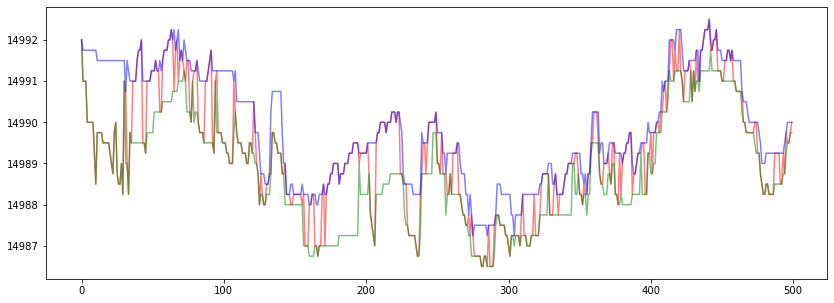

In [14]:
N=500
fig, ax1 = plt.subplots(figsize=(14,5))
ax1.plot(df.iloc[:N]['last'],color='red',alpha=0.5)
ax1.plot(df.iloc[:N]['bid'],color='green',alpha=0.5)
ax1.plot(df.iloc[:N]['ask'],color='blue',alpha=0.5)
plt.show()

In [15]:
# for row in df.iterrows():
for idx, row in df.iterrows():
    print(row['vol'])
    break

27


## convert ticks into volumes

In [513]:
?tqdm.tqdm

In [514]:
val = []
vol = 0
vol_limit = 500
data = []

for idx, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    if vol + row['vol'] == vol_limit:
        vol += row['vol']
        val.append(row['last'])
        data.append([row['date'], val[0],np.max(val), np.min(val),val[-1], vol])
        vol = 0
        val = []
        continue

    if (vol + row['vol'] > vol_limit):
        vol += row['vol']
        while vol > vol_limit:
            val.append(row['last'])
            data.append([row['date'], val[0],np.max(val), np.min(val),val[-1], vol_limit])
            vol -= vol_limit
            val = []
        continue
    vol += row['vol']
    val.append(row['deal'])
#     if idx > 100000:
#         break

100%|██████████| 27483142/27483142 [28:58<00:00, 15806.09it/s]


In [515]:
ddf = pd.DataFrame(data,columns=['date', 'open','high','low','close', 'vol'])
ddf['date'] = pd.to_datetime(ddf['date'].str[:-8])
ddf.head()

date      open      high       low     close  vol
0 2023-10-02 22:00:38  14992.00  14992.25  14986.50  14989.50  500
1 2023-10-02 22:03:41  14989.75  14992.50  14988.25  14990.50  500
2 2023-10-02 22:08:04  14991.00  14992.75  14989.50  14992.00  500
3 2023-10-02 22:13:26  14992.00  14995.00  14987.75  14989.75  500
4 2023-10-02 22:14:44  14989.75  14999.00  14989.75  14997.50  500

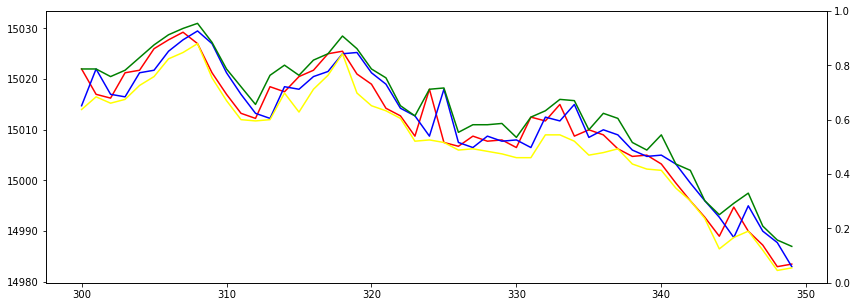

In [516]:
fig, ax1 = plt.subplots(figsize=(14,5))
I = 300
N = 50
ax1.plot( ddf.iloc[I:I+N]['close'], color='red')
ax1.plot( ddf.iloc[I:I+N]['open'], color='blue')
ax1.plot( ddf.iloc[I:I+N]['low'], color='yellow')
ax1.plot( ddf.iloc[I:I+N]['high'],color='green')
# ax1.plot(vals[I:I+N])
ax2 = ax1.twinx() 
# ax2.plot(lmax[:N], color='green')
# ax2.plot(actions[:N], color='green')
# ax1.plot(vals[I:I+N])
# ax2.plot(ddf.iloc[:N]['ft'], color='orange')
plt.show()

In [517]:
# simple check
ddf['vol'].min(), ddf['vol'].max(), ddf.shape

(500, 500, (61833, 6))

In [518]:
ddf['date'].min(),ddf['date'].max()

(Timestamp('2023-10-02 22:00:38'), Timestamp('2023-11-01 20:59:38'))

In [519]:
ddf.to_csv('../data/MNQ DEC23.Last-500-Volume.txt',index=None)


# Fisher Transformation

In [520]:

def fisher_transformation(df,
                          col='close',
                         period = 10):
    # data file should have one column with price data

    # col = 'close'
    period = 10
    fishPrev = 0
    tmpValuePrev = 0
    Value = []
    tmpSeries = []
    for i, v in enumerate(df[col]):
        if i > 0:
            fishPrev = Value[-1]
            tmpValuePrev =  tmpSeries[-1]

        min = df[col].iloc[i-period:i+1].min()
        max = df[col].iloc[i-period:i+1].max()
        if np.isnan(max):
            if i == 0:
                min = v
                max = v
            else:
                min = df[col].iloc[:i+1].min()
                max = df[col].iloc[:i+1].max()
        minLo = min
        num1 = max - minLo
        if num1<0.01:
            num1=0.025
        tmpValue = 0.66 * ((v - minLo)/num1 - 0.5) + 0.67 * tmpValuePrev
        if tmpValue > 0.99:
            tmpValue = 0.999
        elif tmpValue < -0.99:
            tmpValue = -0.99

        tmpSeries.append(tmpValue)
        val = 0.5 * math.log((1+tmpValue)/(1-tmpValue)) + 0.5* fishPrev
        Value.append(val)
    return Value
    #Value - contains final results

In [521]:
vals = fisher_transformation(ddf, 'close',10)
ddf['ft'] = vals
ddf.shape

(61833, 7)

In [522]:
# ddf.to_csv('../data/MNQ SEP23.Last-500-Volume.txt',index=None)
ddf.to_csv('../data/MNQ DEC23.Last-500-Volume.txt',index=None)


In [18]:
ddf = pd.read_csv('../data/MNQ DEC23.Last-500-Volume.txt')
ddf.head()

date      open      high       low     close  vol        ft
0  2023-10-02 22:00:38  14992.00  14992.25  14986.50  14989.50  500 -0.342828
1  2023-10-02 22:03:41  14989.75  14992.50  14988.25  14990.50  500 -0.062081
2  2023-10-02 22:08:04  14991.00  14992.75  14989.50  14992.00  500  0.396141
3  2023-10-02 22:13:26  14992.00  14995.00  14987.75  14989.75  500  0.204056
4  2023-10-02 22:14:44  14989.75  14999.00  14989.75  14997.50  500  0.449363

In [19]:
!ls -fahl ../data

total 1.7G
drwxrwxrwx 1 root root 8.0K Nov  3 05:47  .
drwxrwxrwx 1 root root 4.0K Apr 15  2023  ..
-rwxrwxrwx 1 root root 4.7K Apr 13  2023  fish20230411.txt
-rwxrwxrwx 1 root root 4.6M Nov  2 12:02 'MNQ DEC23.Last-500-Volume.txt'
-rwxrwxrwx 1 root root 1.4G Nov  2 11:17 'MNQ DEC23.Last.txt'
-rwxrwxrwx 1 root root 806K Oct 31 11:44 'MNQ SEP23.Last-500-Volume.txt'
-rwxrwxrwx 1 root root 357K Oct 30 09:43 'MNQ SEP23.Last-Minute.txt'
-rwxrwxrwx 1 root root 232M Oct 30 09:45 'MNQ SEP23.Last-Ticks.txt'
-rwxrwxrwx 2 root root  44M Apr 23  2023  MNQ500days1M20230422.txt
-rwxrwxrwx 2 root root  86M Apr 23  2023  MNQ500daysVolume50020230422.txt.txt
-rwxrwxrwx 2 root root 303K Apr 15  2023  NDX.X.csv
drwxrwxrwx 1 root root 8.0K Apr 16  2023  ninja-trade
-rwxrwxrwx 1 root root 516K Mar 23  2023  nq5years2h.csv
-rwxrwxrwx 1 root root  58K Apr  7  2023  nq_ext.csv


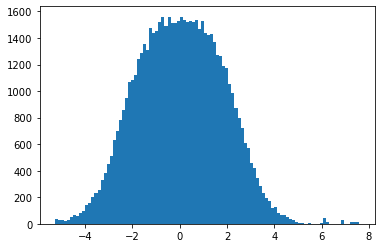

In [524]:
plt.hist(ddf['ft'], bins=100)
plt.show()

In [526]:
ddf['ft'].iloc[1:20]

1    -0.062081
2     0.396141
3     0.204056
4     0.449363
5     0.684623
6     1.064276
7     1.491839
8     1.929496
9     1.805566
10    1.371521
11    0.814375
12    0.299979
13   -0.062195
14   -0.541255
15   -1.037223
16   -1.162436
17   -1.235938
18   -1.374431
19   -1.679000
Name: ft, dtype: float64

# Fisher Local Maximum

In [22]:
def local_max(df, col):
    vals = [1,1]
    for x in tqdm.tqdm(range(df.shape[0]-2)):
        a,b = df[col].iloc[x:x+2]
        # print(a,b)
        if b>a:
            vals.append(1)
            if len(vals)>3:
                if (vals[-2]==-1) & (vals[-3]==1):
                    vals[-2]=1
        else:
            vals.append(-1)
            if len(vals)>3:
                if (vals[-2]==1) & (vals[-3]==-1):
                    vals[-2]=-1
    return vals

In [30]:
lmax = local_max(ddf, 'ft')

100%|██████████| 61831/61831 [00:02<00:00, 26851.88it/s]


In [31]:
assert len(lmax)== ddf.shape[0]
len(lmax), ddf.shape[0]

(61833, 61833)

# Create actions based on the Local Maximum

1 - buy
-1 sell

In [32]:
actions = [0]
for a,b in tqdm.tqdm(zip(lmax[:-1],lmax[1:])):
    if a!=b:
        actions.append(1 if b==1 else -1)
    else:
        actions.append(0)
len(actions)        

61832it [00:00, 1765385.59it/s]


61833

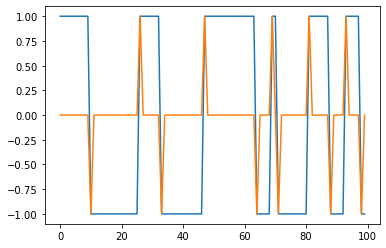

In [33]:
plt.plot(lmax[:100])
plt.plot(actions[:100])

In [34]:
ddf['action'] = actions

In [35]:
ddf.shape

(61833, 8)

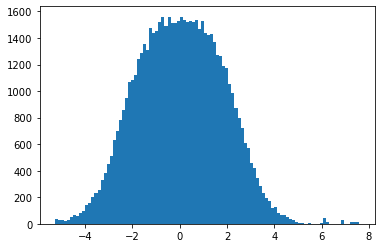

In [36]:
plt.hist(ddf['ft'], bins=100)
plt.show()

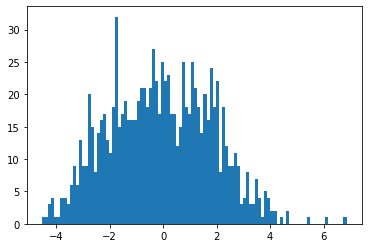

In [37]:
plt.hist(ddf.iloc[:1000]['ft'], bins=100)
plt.show()

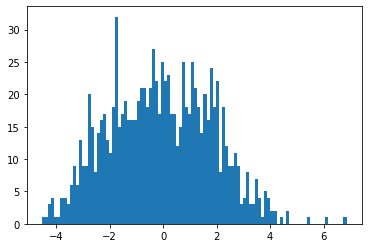

In [38]:
plt.hist(ddf.iloc[:1000]['ft'], bins=100)
plt.show()

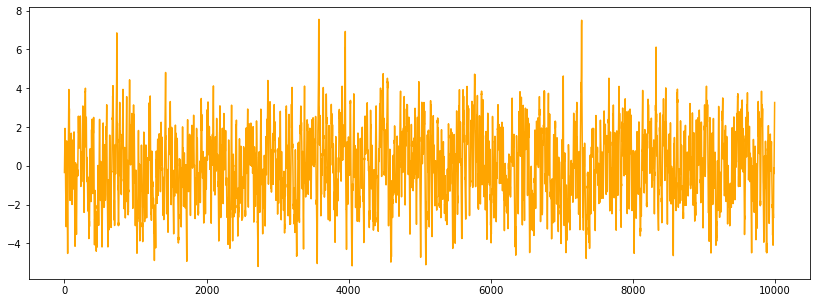

In [39]:
fig, ax1 = plt.subplots(figsize=(14,5))
I = 0
N = 10000
ax1.plot(ddf.iloc[:N]['ft'], color='orange')
# ax1.plot(vals[I:I+N])
# ax2 = ax1.twinx() 
# ax2.plot(lmax[:N], color='green')
# ax2.plot(actions[:N], color='green')
# ax1.plot(vals[I:I+N])
# ax2.plot(ddf.iloc[:N]['ft'], color='orange')

plt.show()

In [40]:
ddf.shape

(61833, 8)

In [42]:
in_row = [ 1 if lmax[0]==1 else -1]
grow = lmax[0]==1
for a, b in zip(lmax[:-1],lmax[1:]):
    if (a==b):
        in_row[-1]+= 1 if b==1 else -1
        continue
    else:
        in_row.append(1 if b==1 else -1)

In [131]:
in_row[:10]

[10, -16, 7, -14, 17, -5, 2, -10, 7, -5]

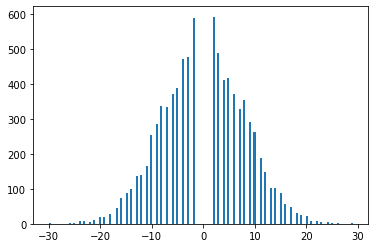

In [44]:
plt.hist(in_row,bins=150)
plt.show()

In [45]:
ddf

date      open      high       low     close  vol  \
0      2023-10-02 22:00:38  14992.00  14992.25  14986.50  14989.50  500   
1      2023-10-02 22:03:41  14989.75  14992.50  14988.25  14990.50  500   
2      2023-10-02 22:08:04  14991.00  14992.75  14989.50  14992.00  500   
3      2023-10-02 22:13:26  14992.00  14995.00  14987.75  14989.75  500   
4      2023-10-02 22:14:44  14989.75  14999.00  14989.75  14997.50  500   
...                    ...       ...       ...       ...       ...  ...   
61828  2023-11-01 20:45:32  14757.25  14758.75  14754.00  14756.75  500   
61829  2023-11-01 20:48:32  14756.75  14759.00  14753.75  14754.50  500   
61830  2023-11-01 20:53:23  14754.50  14757.00  14753.00  14756.00  500   
61831  2023-11-01 20:56:02  14756.25  14760.00  14753.25  14755.75  500   
61832  2023-11-01 20:59:38  14755.75  14760.00  14753.00  14760.00  500   

             ft  action  
0     -0.342828       0  
1     -0.062081       0  
2      0.396141       0  
3      0.204056       0  
4      0.449363       0  
...         ...     ...  
61828  2.864658       0  
61829  2.629622       0  
61830  2.526632      -1  
61831  2.445323       0  
61832  2.620189       0  

[61833 rows x 8 columns]

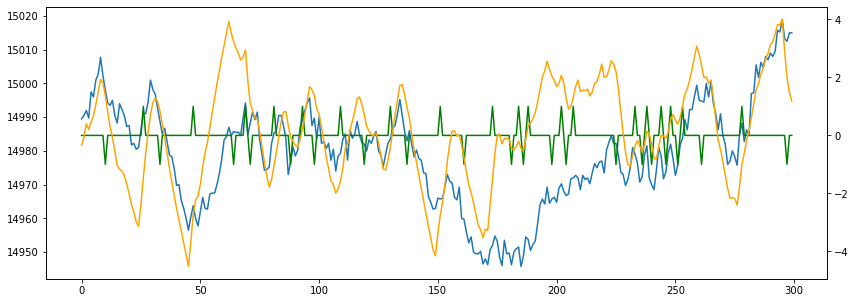

In [46]:
fig, ax1 = plt.subplots(figsize=(14,5))
I = 300
N = 300
ax1.plot( ddf.iloc[:N]['close'])
# ax1.plot(vals[I:I+N])
ax2 = ax1.twinx() 
# ax2.plot(lmax[:N], color='green')
ax2.plot(actions[:N], color='green')
# ax1.plot(vals[I:I+N])
ax2.plot(ddf.iloc[:N]['ft'], color='orange')
plt.show()

In [47]:
?ax2.hlines

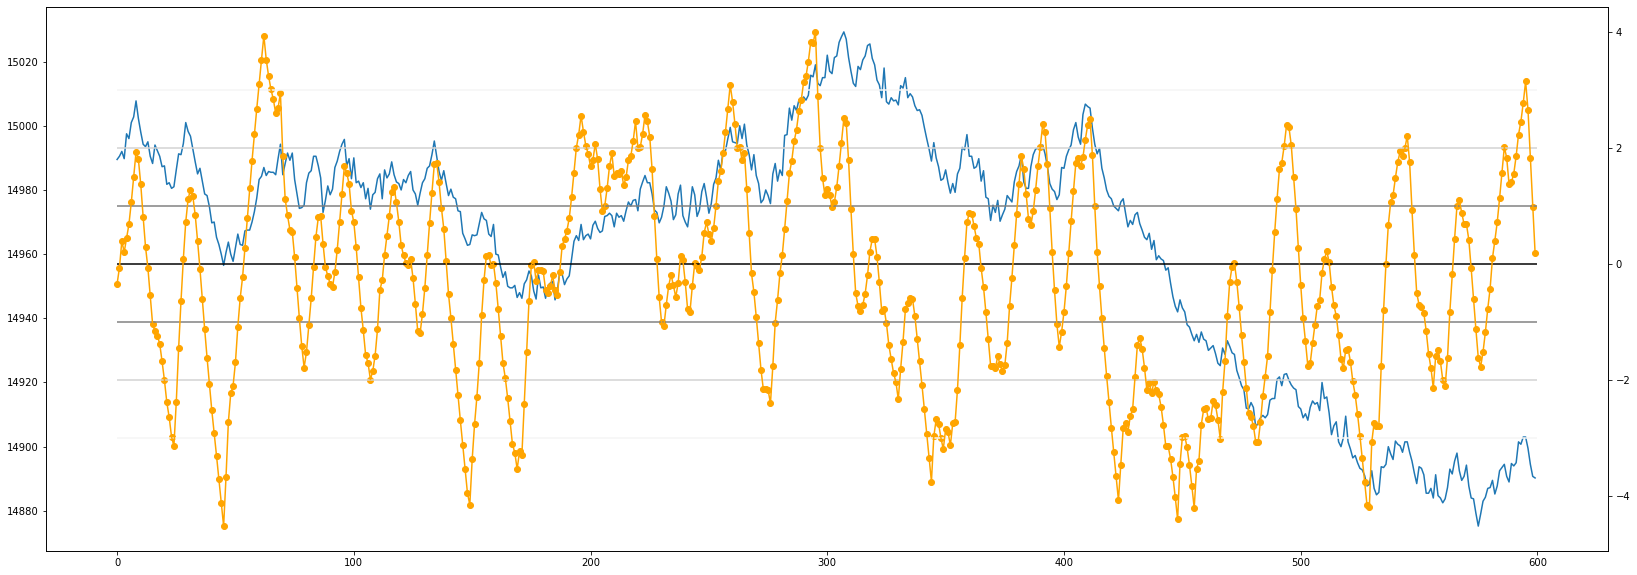

In [129]:
fig, ax1 = plt.subplots(figsize=(28,10))
I = 300
N = 600
ax1.plot( ddf.iloc[:N]['close'])
# ax1.plot(vals[I:I+N])
ax2 = ax1.twinx() 
# ax2.plot(lmax[:N], color='green')
# ax2.plot(actions[:N], color='green')
# ax1.plot(vals[I:I+N])
ax2.hlines(0,0,N, color='black')
ax2.hlines(1,0,N, color='grey')
ax2.hlines(-1,0,N, color='grey')
ax2.hlines(-2,0,N, color='lightgrey')
ax2.hlines(2,0,N, color='lightgrey')

ax2.hlines(3,0,N, color='whitesmoke')
ax2.hlines(-3,0,N, color='whitesmoke')
ax2.plot(ddf.iloc[:N]['ft'], color='orange')
ax2.scatter(range(N),ddf.iloc[:N]['ft'], color='orange')
plt.show()

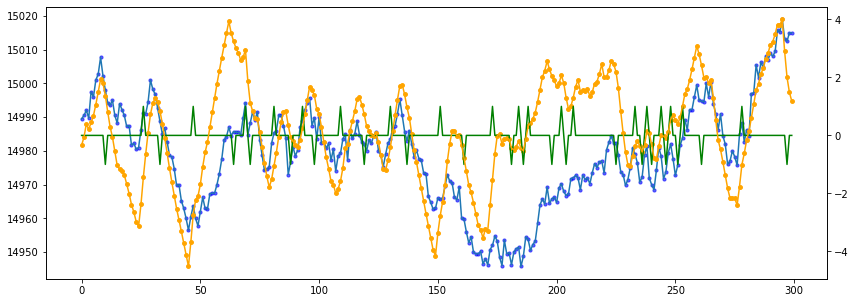

In [66]:
I = 300
N = 300
ddf_data = ddf.iloc[:N]
ft_data = ddf_data['ft']
N_data = range(N)

fig, ax1 = plt.subplots(figsize=(14,5))
ax1.plot   (        ddf_data['close'])
ax1.scatter(N_data, ddf_data['close'], color='blue', s=10,alpha=0.6)

ax2 = ax1.twinx() 
ax2.plot(actions[:N], color='green')
ax2.plot(          ft_data, color='orange')
ax2.scatter(N_data,ft_data, color='orange',s=15)

plt.show()

# Visualization of the actions

In [67]:
from math import pi
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, show
from bokeh.resources import INLINE

output_notebook(resources=INLINE)
# from bokeh.sampledata.stocks import MSFT

Loading BokehJS ...

In [75]:
?p.triangle

In [99]:
# https://docs.bokeh.org/en/2.4.3/docs/gallery/candlestick.html
# https://techflare.blog/how-to-draw-a-candlestick-chart-with-dataframe-in-python-mplfinance-plotly-and-bokeh/

df = ddf.iloc[:5000]
inc = df.close > df.open
dec = df.open > df.close
ask = df.action ==  1
bid = df.action == -1
w = 0.6
x_data = np.array(range(df.shape[0]))
TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

x_range = (0, 150)
y_range = (df[:x_range[1]]['high'].min()-5, df[:x_range[1]]['high'].max()+5)

p = figure(x_axis_type="datetime", tools=TOOLS, width=1000, title = "MNQ", x_range=x_range,  y_range=y_range )
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3

p.segment(x_data, df.high, x_data, df.low, color="black")
p.vbar(x_data[inc], w, df.open[inc], df.close[inc], fill_color="green", line_color="black")
p.vbar(x_data[dec], w, df.open[dec], df.close[dec], fill_color="red", line_color="black")
p.triangle(x_data[ask], df.low[ask]-1,  fill_color='green', line_color='green', size=6)
p.triangle(x_data[bid], df.high[bid]+1, fill_color='red',   line_color='red',   size=7, angle=1.04)

show(p)

# TRADING STRATEGY!
## trading simulation

In [108]:
def a(ac):
    return 'B' if ac == 1 else ('S' if ac==-1 else '-')

ledger = []
current_action = [0,0,0]
open_positions = []
budget = 200
budgets = []
volume = 1

# iterate throw rows filterd Action column which are != 0
for idx, row in tqdm.tqdm(ddf[ddf['action']!=0].iterrows()):
    action = row['action']
    budgets.append(budget)

    # first trade
    if len(open_positions) == 0:
        # price, volume
        # action_price = 'open' if action == 1 else 'open'
        action_price = 'open'
        open_positions.append([row[action_price], volume, action, row['ft']])

        p0, v0, a0, ft0 = open_positions[0]
        if idx <100:
            print(idx, 0.0, budget, f'P0:{p0} {a0} {a(a0)}, FT:{ft0}')
        continue

    if  open_positions[0][2]==(-1)*action:
        # action_price = 'open' if action == 1 else 'open'
        
        p0,v0,a0,ft0 = open_positions[0]
        p1,v1,a1,ft1 = row[action_price],volume, action, row['ft']
        open_positions.pop(0)
        
        if a0 == 1: # SELL
            pl = p0*v0 - p1*v1
        else:
            pl = p1*v1 - p0*v0
        budget += pl
        if idx <100:
            print(idx, pl,budget, f'P0:{p0} {a(a0)} FT:{ft0:0.2}', f'P1:{p1} {a(a1)} FT:{ft1:0.2}')
        ledger.append([len(ledger), p0, p1, pl, a0, ft0, ft1])
        
        # reverse position
        open_positions.append([row[action_price], volume, action, row['ft']])

#         break
    

1974it [00:00, 10080.59it/s]

10 0.0 200 P0:15002.25 -1 S, FT:1.3715212564960733
26 -16.0 184.0 P0:15002.25 S FT:1.4 P1:14986.25 B FT:-1.5
33 -6.5 177.5 P0:14986.25 B FT:-1.5 P1:14992.75 S FT:0.85
47 -32.25 145.25 P0:14992.75 S FT:0.85 P1:14960.5 B FT:-2.7
64 -24.0 121.25 P0:14960.5 B FT:-2.7 P1:14984.5 S FT:3.2
69 5.25 126.5 P0:14984.5 S FT:3.2 P1:14989.75 B FT:2.9
71 5.0 131.5 P0:14989.75 B FT:2.9 P1:14984.75 S FT:1.1
81 -2.5 129.0 P0:14984.75 S FT:1.1 P1:14982.25 B FT:-1.0
88 9.25 138.25 P0:14982.25 B FT:-1.0 P1:14973.0 S FT:-0.059
93 14.0 152.25 P0:14973.0 S FT:-0.059 P1:14987.0 B FT:0.25
98 -0.5 151.75 P0:14987.0 B FT:0.25 P1:14987.5 S FT:1.4


8721it [00:00, 11700.07it/s]


In [109]:
len(ledger)

8720

In [110]:
#         ledger        .append([row[action_price], volume, action])
ldf = pd.DataFrame(ledger, columns=['idx','open','close', 'pnl', 'action', 'openft','closeft'])
ldf.head()

idx      open     close    pnl  action    openft   closeft
0    0  15002.25  14986.25 -16.00      -1  1.371521 -1.450445
1    1  14986.25  14992.75  -6.50       1 -1.450445  0.845782
2    2  14992.75  14960.50 -32.25      -1  0.845782 -2.729398
3    3  14960.50  14984.50 -24.00       1 -2.729398  3.240847
4    4  14984.50  14989.75   5.25      -1  3.240847  2.946741

In [111]:
ldf['pnl'].describe()

count    8720.000000
mean       -2.078928
std         9.008320
min      -101.750000
25%        -6.750000
50%         0.250000
75%         4.250000
max        71.750000
Name: pnl, dtype: float64

In [112]:
import matplotlib.cm as cm
# https://stackoverflow.com/questions/31869732/getting-color-from-0-1-range-in-matplotlib

In [127]:
len(sc_pnl), len(sc_pnl[sc_pnl>=0]), len(sc_pnl[sc_pnl<=0])

(8720, 4534, 4292)

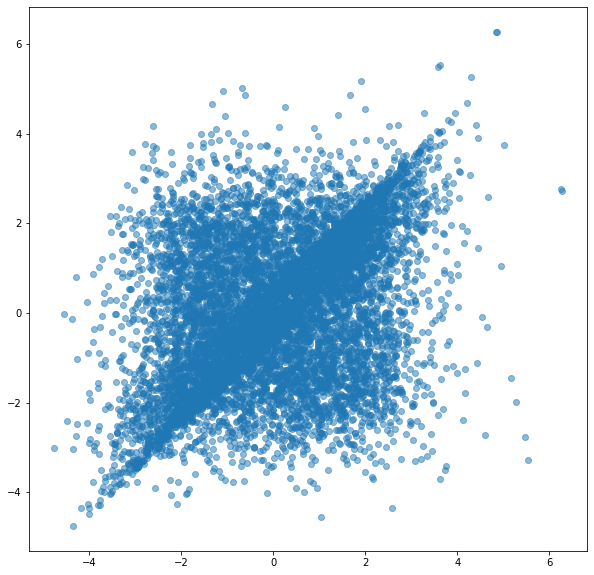

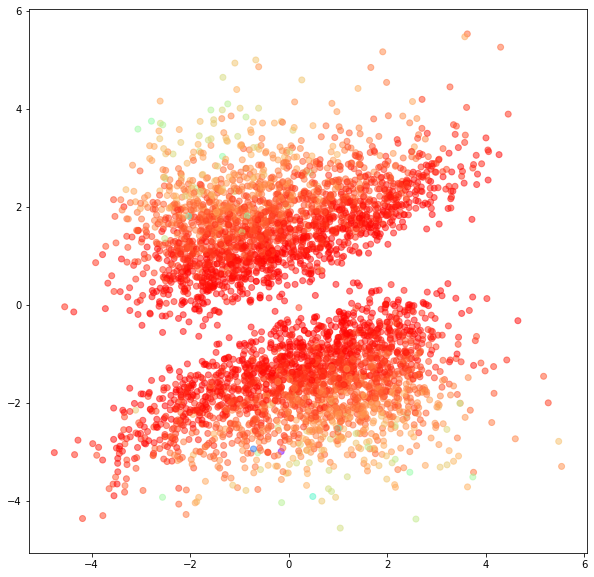

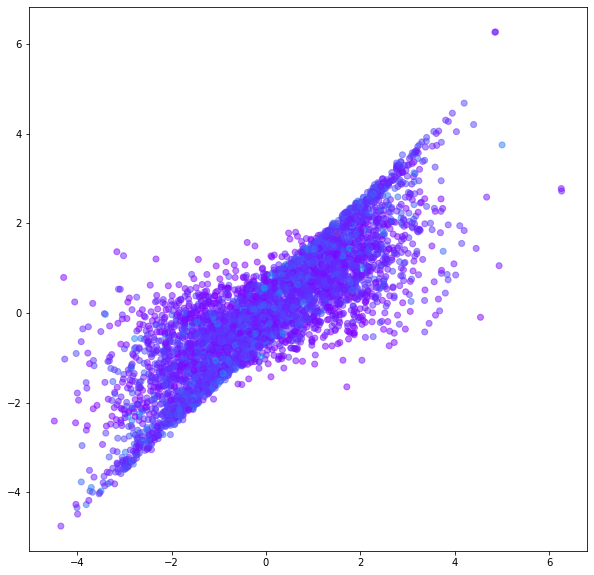

In [123]:
ldf_filter = np.abs(ldf['openft']) >= 0
sc_openft = ldf[ldf_filter]['openft']
sc_closeft = ldf[ldf_filter]['closeft']
sc_pnl = ldf[ldf_filter]['pnl']

plt.figure(figsize=(10,10))
plt.scatter(sc_openft, sc_closeft, alpha=0.5)#, c=sc_pnl, cmap=cm.rainbow)
plt.show()

pnl_filter = sc_pnl < 0
plt.figure(figsize=(10,10))
plt.scatter(sc_openft[pnl_filter], sc_closeft[pnl_filter], alpha=0.5, c=sc_pnl[pnl_filter], cmap=cm.rainbow)
plt.show()


pnl_filter = sc_pnl > 0
plt.figure(figsize=(10,10))
plt.scatter(sc_openft[pnl_filter], sc_closeft[pnl_filter], alpha=0.5, c=sc_pnl[pnl_filter], cmap=cm.rainbow)
plt.show()

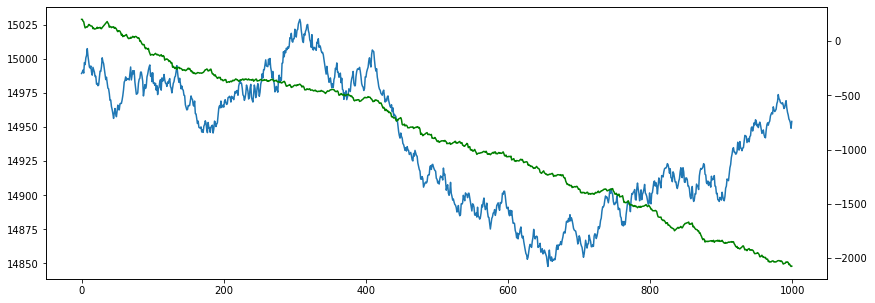

In [117]:
fig, ax1 = plt.subplots(figsize=(14,5))
I = 0
N = 1000
ax1.plot( ddf.iloc[:N]['close'])
# ax1.plot(vals[I:I+N])
ax2 = ax1.twinx() 
ax2.plot(budgets[:N], color='green')
# ax2.plot(lmax[:N], color='green')
# ax2.plot(actions[:N], color='green')
# ax1.plot(vals[I:I+N])
# ax2.plot(ddf.iloc[:N]['ft'], color='orange')
plt.show()

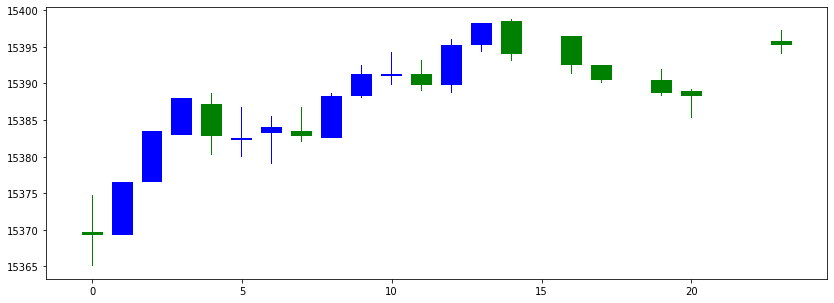

In [379]:
# https://www.geeksforgeeks.org/how-to-create-a-candlestick-chart-in-matplotlib/
I = 0
N = 10

up = ddf[ddf.close >= ddf.open].iloc[I:I+N]
down = ddf[ddf.close < ddf.open].iloc[I:I+N]
col1 = 'blue'
col2 = 'green'

# Setting width of candlestick elements 
width = .7
width2 = .03

plt.figure(figsize=(14,5))
# Plotting up prices of the stock 
plt.bar(up.index, up.close-up.open, width,  bottom=up.open,  color=col1) 
plt.bar(up.index, up.high-up.close, width2, bottom=up.close, color=col1) 
plt.bar(up.index, up.low-up.open,   width2, bottom=up.open,  color=col1) 
  
# Plotting down prices of the stock 
plt.bar(down.index, down.close-down.open, width,  bottom=down.open,  color=col2) 
plt.bar(down.index, down.high-down.open,  width2, bottom=down.open,  color=col2) 
plt.bar(down.index, down.low-down.close,  width2, bottom=down.close, color=col2) 
  
# rotating the x-axis tick labels at 30degree  
# towards right 
# plt.xticks(rotation=30, ha='right') 
  
# displaying candlestick chart of stock data  
# of a week 
plt.show() 
